$$\require{mhchem}$$
# Monod-type denitrification model

In this notebook I use the Monod equations proposed by Störiko et al. 2021 and 2022.

Reactions (Störiko et al 2021):

1. *denitrification 1*: $\ce{7NO3- + C4H6O4 ->[nar] 7NO2- + 4CO2 + 3H2O}$
2. *denitrificantion 2*: $\ce{14NO2- + 14H+ + 3C4H6O4 ->[nir] 7N2 + 12CO2 + 16H2O}$
3. *aerobic respiration*: $\ce{7O2 + 2C4H6O4 -> 7NO2- + 8CO2 + 6H2O}$
---------------
In this model, denitrification rates are described by a Monod term:

$r_{j} = \nu_{max}^i B \frac{C_{j}}{C_{j} + K_{j}} \frac{I_{reac}^i}{I_{reac}^i + C_{O2}} $

for $j \in (nar, nir)$

the aerobic respiration is also described by another monod term:

$r_{\ce{O2}} = \nu_{\ce{O2}}^i B \frac{C_{\ce{O2}}}{C_{\ce{O2}} + K_{\ce{O2}}} \frac{C_{\ce{DOC}}}{C_{\ce{DOC}} + K_{\ce{DOC}}} $  

--------------------
DOC consumption is modelled by adding the stoichiometric corrected rates from the denitrification and aerobic oxidation rates:

$r_{\ce{DOC}}^{j} = \frac{\gamma_{\ce{DOC}}^{j}}{\gamma_{\ce{A}}^{j}}*r_{j}$

for $j \in (nar, nir, \ce{O2})$

and the full rate is defined by the expression:

$r_{DOC} = \sum_j r_{DOC}^j$

DOC release from the sediment contained POC is modelled with the expression:

$r_{rel} = k_{rel}^{DOC}*(C_{DOC}^{sat}- C_{DOC}) $

The final expression for change in $\ce{DOC}$ is then:

$\frac{d[DOC]}{dt} = r_{rel} - r_{DOC} $

---------------------

Bacterial growth is represented by the following reaction:

$\ce{3C4H6O4 + 2NH4+ -> C10H18O5N2 + 2CO2 + 3H2O + 2H+}$

$\ce{NH4+}$ is assumed non limiting. Thus biological growth is modelled with the following expression:

$r_{growth}^{i} = Y_i*r_{DOC}^i$ 

And the specific yield of each consumption reaction is modelled by a logistic function assuming a maximum bacterial growth:

$Y_i = Y_{i,max}*\left(1-\frac{B}{B_{max}}\right)$

Bacterial decay modelled with first order rate:

$r_{dec} = k_{dec}*B$

The final expression for bacterial density change is:

$ \frac{dB}{dt} = \sum_i r_{growth}^{i} - r_{dec}$

#### importing libraries

In [1]:
import os
import numpy as np
import scipy
import sunode
import matplotlib.pyplot as plt

## Define the RHS


In [2]:
def rhs(t, y, p):
    # Enzime rates:
    r_nar = p.nu_no3*y.B*y.no3/(y.no3+p.Kno3)*(p.Ino3/(p.Ino3+y.o2))
    r_nir = p.nu_no2*y.B*y.no2/(y.no2+p.Kno2)*(p.Ino2/(p.Ino2+y.o2))
    # Nitrate and nitrite rates:
    dno3dt = -r_nar
    dno2dt = r_nar-r_nir
    #O2 rate
    do2dt = -p.nu_o2*y.B*y.o2/(y.o2+p.Ko2)*(y.doc/(y.doc+p.Kdoc))
    #DOC rate
    ddocdt = -(1/7)*r_nar+(-(3/14)*r_nir)+(-(2/7)*do2dt)+p.k_rel*(p.c_sat-y.doc)
    # B rate:
    Y_nar = p.Y_narmax*(1-y.B/p.Bmax) 
    Y_nir = p.Y_nirmax*(1-y.B/p.Bmax)
    Y_o2 = p.Y_o2max*(1-y.B/p.Bmax)
    dBdt = (1/7)*r_nar*Y_nar + (3/14)*r_nir*Y_nir + (2/7)*do2dt*Y_o2 -p.k_dec*y.B
    return np.array([dno3dt,dno2dt,do2dt,ddocdt,dBdt]) #rhs form
    

# Define the Transport Model

The model we use the is an implicit model in time and discretized in space that solved internally with an ODE solver from scipy (odeint).
To run the model, first we must define the parameters.

## Parameters

We define a dictionary will all the static parameters

In [3]:
parameters = {}

#### transport parameters

In [4]:
parameters['length'] = 0.4 #m
parameters['D'] = np.array([3e-8,3e-8,3e-8,3e-8])
parameters['alpha_l'] = 7e-3
v = 1e-6
ncells = np.ceil(parameters['length']*v/(0.1*(np.min(parameters['D'])+parameters['alpha_l']*v)))
ncells = int(ncells)
parameters['ncells'] = ncells
ncells


109

#### NO3 reaction parameters

In [5]:
nu_no3 = 7.1e-17 #mols/cells*s
K_no3 = 5e-6 #M
K_doc_3 = 40e-6 #M
I_o2_3 = 5.9e-8 #M
no3_args = (nu_no3,K_no3,K_doc_3,I_o2_3)

In [6]:
parameters['no3_args'] = no3_args

#### NO2 reaction parameters

In [7]:
nu_no2 = 4.8e-17 #mols/cells*s
K_no2 = 5e-6 #M
K_doc_2 = 40e-6 #M
I_o2_2 = 5.1e-8 #M
no2_args = (nu_no2,K_no2,K_doc_2,I_o2_2)

In [8]:
parameters['no2_args'] = no2_args

#### O2 reaction parameters

In [9]:
nu_o2 = 6.4e-17 #mols/cells*s
K_o2_o = 3.1e-5
K_doc_o = 40e-6
o2_args = (nu_o2,K_o2_o,K_doc_o)

In [10]:
parameters['o2_args'] = o2_args

#### DOC reaction parameters

In [11]:
K_rel = 0.2/(3600*24) #s-1
C_sat = 20.8e-3 #mol/L
doc_args = (K_rel, C_sat)

In [12]:
parameters['doc_args'] = doc_args

#### B reaction parameters

In [13]:
Y_max = np.array([2.6e13,1.6e13,7.7e13])
K_dec = 1e-12
B_max = 3.3e11
B_args = (Y_max,K_dec,B_max)

In [14]:
parameters['B_args'] = B_args

### Stress Periods

We define the stress period as the period with constant boundary values it is organized in a list with the time start of each boundary condition and the boundary values of such stress period

In [15]:
tchange = np.array([0,3600*4,3600*12])
c_in_array = np.array([[0.6,0.03,1e-7,0.1],[0.6,0.03,1e-7,0.1],[0.6,0.03,0.02,0.1]])
v_in = np.array([v,v,v])

In [16]:
v_in[0]

1e-06

In [17]:
stress_periods = [tchange, c_in_array, v_in]

### Running model

In [18]:
import sys
sys.path.append('../../')

importing the model:

In [19]:
from src.models.storiko_model import column_model_storiko

In [20]:
time_intervals = np.arange(0, 3600*250+600, 600)

In [21]:
np.exp(np.log(10))

10.000000000000002

In [22]:
sol = column_model_storiko(stress_periods, parameters, time_intervals, hmax = (parameters['length']/parameters['ncells'])**2/(8*(parameters['D'][0]+parameters['alpha_l']*v)))

C:\Users\Vitor Cantarella\OneDrive\Kassel\secunda\notebooks\reaction_experiments\../..\src\models\storiko_model.py:43: RuntimeWarning: invalid value encountered in log
  r = nu_nox*B*np.exp(np.log(C_nox)-np.log(C_nox+K_nox))*np.exp(np.log(C_doc)-np.log(C_doc+K_doc))*np.exp(np.log(I_o2)-np.log(I_o2+C_o2))
C:\Users\Vitor Cantarella\miniconda3\envs\nitrogene-env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Vitor Cantarella\OneDrive\Kassel\secunda\notebooks\reaction_experiments\../..\src\models\storiko_model.py:43: RuntimeWarning: divide by zero encountered in log
  r = nu_nox*B*np.exp(np.log(C_nox)-np.log(C_nox+K_nox))*np.exp(np.log(C_doc)-np.log(C_doc+K_doc))*np.exp(np.log(I_o2)-np.log(I_o2+C_o2))
C:\Users\Vitor Cantarella\OneDrive\Kassel\secunda\notebooks\reaction_experiments\../..\src\models\storiko_mode

### Analytical solution:

In [23]:
def analytical(t,c_in,L,v,Dl,R):
    c = (c_in/2)*(scipy.special.erfc((L-v*t/R)/(np.sqrt(4*Dl*t/R)))+np.exp(np.exp(np.log(v*L)-np.log(Dl)))*
                  scipy.special.erfc(np.exp(np.log(L+v*t/R)-np.log(np.sqrt(4*Dl*t/R)))))
    return c

In [24]:
c_out_ana = np.zeros(time_intervals.shape)
Dl = parameters['D'][0]+v*parameters['alpha_l']
R = 1
for i in range(time_intervals.shape[0]):
    c_out_ana[i] = analytical(time_intervals[i],c_in_array[0,0],parameters['length'],v,Dl,R) 
    

C:\Users\Vitor Cantarella\AppData\Local\Temp\ipykernel_12484\1861471515.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  c = (c_in/2)*(scipy.special.erfc((L-v*t/R)/(np.sqrt(4*Dl*t/R)))+np.exp(np.exp(np.log(v*L)-np.log(Dl)))*
C:\Users\Vitor Cantarella\AppData\Local\Temp\ipykernel_12484\1861471515.py:3: RuntimeWarning: divide by zero encountered in log
  scipy.special.erfc(np.exp(np.log(L+v*t/R)-np.log(np.sqrt(4*Dl*t/R)))))


In [25]:
def f(t,y,deltax,
      D,
      alpha_l,
      v,
      c_in):
    
    mixf = (D + v*alpha_l)/deltax**2
    
    r = np.zeros(y.shape[0])
    c_0half = y[1]/4-c_in/2+5*y[0]/4
    
    r[0] = -v*(y[0]-c_in)/(deltax/2) + (-mixf)*y[0] + mixf*y[1]
    
    #Update the middle_portion
    sliding_window = np.lib.stride_tricks.sliding_window_view(y, (3))
    kernel = np.array([mixf, -2*mixf, mixf])
    r[1:-1] = np.dot(sliding_window,kernel)
    #Update the last cell:
    r[-1] = mixf*y[-1-1] + (-mixf)*y[-1]
    r[1:-1] = r[1:-1]-v*(np.roll(y,-1)[1:-1]-np.roll(y,1)[1:-1])/(2*deltax)
    r[-1] = r[-1]-v*(y[-1]-y[-2])/deltax
    return r
    


In [26]:
def jacob(t, y, deltax,D,alpha_l,v,c_in):
    mixf = (D + v*alpha_l)/deltax**2
    adv_step = v/deltax
    size = y.shape[0]
    j = np.zeros((size,size))
    j[0,0] = -v/(deltax/2)-mixf
    j[0,1] = mixf
    for i in range(1,size-1):
        j[i,i-1] = -v/(2*deltax) + mixf
        j[i,i] = -2*mixf
        j[i,i+1] = v/(2*deltax) + mixf
    j[size-1,size-2] = v/deltax + mixf
    j[size-1,size-1] = -v/deltax - mixf
    return j

### Coupled ODESolver approach

This process is not mature yet, however we can get an accurate result with a very large number of cells.

In [27]:
n_cells = parameters['ncells']
deltax = parameters['length']/parameters['ncells']
y0 = np.repeat(1e-11,n_cells)
y0

array([1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11])

In [28]:
mixf = (parameters['D'][0]+v*parameters['alpha_l'])/deltax**2
r = np.zeros(y0.shape[0])

In [29]:
c_ode, outp = scipy.integrate.odeint(f,y0,time_intervals,args = (deltax,parameters['D'][0],parameters['alpha_l'],v,c_in_array[0,0]), 
                                     Dfun = jacob,
                                     tfirst = True,
                                     #hmax = 0.1*deltax**2/(3*(parameters['D'][0]+v*parameters['alpha_l'])),
                                     atol = 1e-13, rtol = 1e-13, full_output = 1)

### Trying with the Sunode solver.

Now I have to declare the parameters as a params dictionary:

In [30]:
params = {
    'deltax' : (),
    'D': (),
    'alpha_l': (),
    'v': (),
    'c_in': (),
    }

In [31]:
states = {
    'c': y0.shape
    }

In [32]:
import sympy as sp

In [33]:
M = sp.zeros(y0.shape[0],1)

In [34]:
def sun_f(t,y,p):
    
    mixf = (p.D + p.v*p.alpha_l)/p.deltax**2
    
    r = sp.zeros(y.c.shape[0],1)
    
    
    r[0] = -p.v*(y.c[0]-p.c_in)/(p.deltax/2) + (-mixf)*y.c[0] + mixf*y.c[1]
    
    #Update the middle_portion
    for i in range(1,y.c.shape[0]-1):
        r[i] = r[i] + mixf*y.c[i-1] - 2*mixf*y.c[i] + mixf*y.c[i+1]
    #sliding_window = np.lib.stride_tricks.sliding_window_view(y.c, (3))
    #kernel = np.array([mixf, -2*mixf, mixf])
    #r[1:-1] = np.dot(sliding_window,kernel)
    #Update the last cell:
    r[-1] = mixf*y.c[-1-1] + (-mixf)*y.c[-1]
    for i in range(1,y.c.shape[0]-1):
        r[i] = r[i] -p.v*(y.c[i+1] - y.c[i-1])/(2*p.deltax)
    #r[1:-1] = r[1:-1]-p.v*(np.roll(y.c,-1)[1:-1]-np.roll(y.c,1)[1:-1])/(2*p.deltax)
    r[-1] = r[-1]-p.v*(y.c[-1]-y.c[-2])/p.deltax
    r = list(r)
    return {'dcdt' : r}

In [35]:
import sunode

#### Plotting and comparing solutions:

In [36]:
plot_time = time_intervals/3600

Text(0, 0.5, '[C3H6O2] [$mol/L$]')

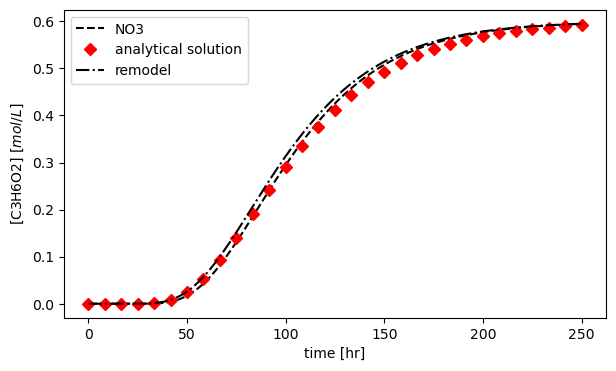

In [37]:
fig = plt.figure(figsize = (7,4))
ax = fig.add_subplot(111)
ax.plot(plot_time,sol[:,0],'--k', label = 'NO3')
ax.plot(plot_time[::50],c_out_ana[::50], 'Dr', label = 'analytical solution')
ax.plot(plot_time,c_ode[:,-1],'-.k', label = 'remodel')
#ax.set_xlim([0,6])
ax.legend()
ax.set_xlabel('time [hr]')
ax.set_ylabel(r'[C3H6O2] [$mol/L$]')

Text(0, 0.5, '[C3H6O2] [$mol/L$]')

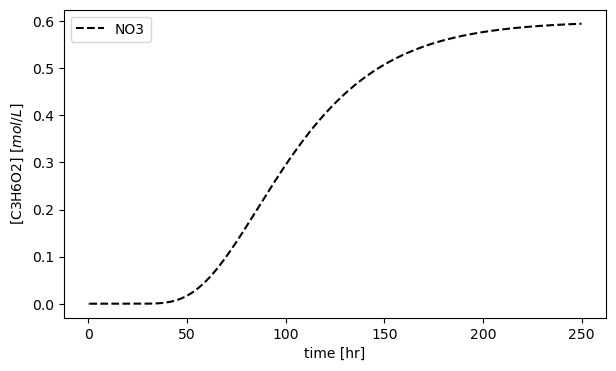

In [45]:
fig = plt.figure(figsize = (7,4))
ax = fig.add_subplot(111)
ax.plot(plot_time,sol[:,0],'--k', label = 'NO3')
#ax.plot(plot_time[::50],c_out_ana[::50], 'Dr', label = 'analytical solution')
#ax.plot(plot_time,c_ode[:,-1],'-.k', label = 'remodel')
#ax.set_xlim([0,6])
ax.legend()
ax.set_xlabel('time [hr]')
ax.set_ylabel(r'[C3H6O2] [$mol/L$]')

In [47]:
sol[50:100,1]

array([2.11270304e-28, 1.52721457e-27, 9.83824468e-27, 5.70265863e-26,
       2.99992840e-25, 1.44329909e-24, 6.39453879e-24, 2.62521998e-23,
       1.00429000e-22, 3.59825251e-22, 1.21300015e-21, 3.86352206e-21,
       1.16711705e-20, 3.35556682e-20, 9.21130360e-20, 2.42129830e-19,
       6.11100093e-19, 1.48451658e-18, 3.47899710e-18, 7.88190358e-18,
       1.72965340e-17, 3.68313993e-17, 7.62310592e-17, 1.53593165e-16,
       3.01691013e-16, 5.78474833e-16, 1.08412578e-15, 1.98816846e-15,
       3.57171551e-15, 6.29204658e-15, 1.08795613e-14, 1.84808612e-14,
       3.08664974e-14, 5.07279816e-14, 8.20962118e-14, 1.30922758e-13,
       2.05876703e-13, 3.19423196e-13, 4.89265741e-13, 7.40252753e-13,
       1.10687018e-12, 1.63646620e-12, 2.39338122e-12, 3.46418660e-12,
       4.96426886e-12, 7.04603209e-12, 9.90903037e-12, 1.38123835e-11,
       1.90898705e-11, 2.61681477e-11])

In [40]:
def r_nox_monod(nu_nox,K_nox,K_doc,I_o2,C_nox,C_doc,C_o2,B):
    '''
    monod type rate for denitrification. Valid for NO3 and NO2 denitrification rates See Störiko 2021, and 2022.
    '''
        
    r = nu_nox*B*np.exp(np.log(C_nox)-np.log(C_nox+K_nox))*np.exp(np.log(C_doc)-np.log(C_doc+K_doc))*np.exp(np.log(I_o2)-np.log(I_o2+C_o2))
    return r

In [41]:
r_nox_monod(nu_no3,K_no3,K_doc_3,I_o2_3,sol[0,0],sol[0,3],sol[0,2],sol[0,4])*Y_max[0]

3.045376981148864e-06

In [42]:
K_dec*sol[0,4]

0.0033